In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
import pathlib

files = "/kaggle/input/water-bottle-dataset"
data_dir = pathlib.Path(files)
labels = os.listdir(files)
print(labels)


['Full  Water level', 'Half water level', 'Overflowing']


In [2]:
full_files = "/kaggle/input/water-bottle-dataset/Full  Water level/Full  Water level"
half_files = "/kaggle/input/water-bottle-dataset/Half water level/Half water level"
overflow_files = "/kaggle/input/water-bottle-dataset/Overflowing/Overflowing"
image_count = len(list(data_dir.glob('*/*/*.jpeg')))

print("Image count: ", image_count)

print("Files with full water bottles: ", len([entry for entry in os.listdir(full_files) if os.path.isfile(os.path.join(full_files, entry))]))
print("Files with half full water bottles: ", len([entry for entry in os.listdir(half_files) if os.path.isfile(os.path.join(half_files, entry))]))
print("Files with overflowing water bottles: ", len([entry for entry in os.listdir(overflow_files) if os.path.isfile(os.path.join(overflow_files, entry))]))
#486 files in total

Image count:  429
Files with full water bottles:  308
Files with half full water bottles:  139
Files with overflowing water bottles:  39


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from sklearn.metrics import classification_report,confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers
import PIL
import cv2
import shutil

In [4]:
batch_size = 32
img_height = 128
img_width = 128

train_set = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

val_set = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 486 files belonging to 3 classes.
Using 389 files for training.
Found 486 files belonging to 3 classes.
Using 97 files for validation.


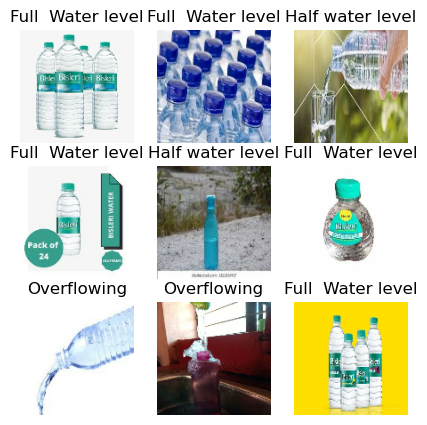

In [5]:
labels = val_set.class_names
plt.figure(figsize=(5, 5))
for images, label in train_set.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(labels[label[i]])
    plt.axis("off")

In [6]:
#Configuring data
tune = tf.data.AUTOTUNE

train_set = train_set.cache().shuffle(1000).prefetch(buffer_size = tune)
val_set = val_set.cache().prefetch(buffer_size = tune)

In [7]:
#Data Augmentation
data_aug = keras.Sequential(
    [
        layers.RandomFlip(
            'horizontal',
            input_shape = (
                img_height,
                img_width,
                3
            )
        ),
        
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ]
)

In [8]:
#Creating the model
label_count = len(labels)

model = Sequential([
    data_aug,
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding = 'same', activation = 'relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding = 'same', activation = 'relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(56, 3, padding = 'same', activation = 'relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation = 'relu'),
    layers.Dense(label_count, name = 'outputs')
])

In [9]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    metrics = ['accuracy']
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                  

In [10]:
epochs = 20

history = model.fit(
    train_set,
    validation_data = val_set,
    epochs = epochs
)

Epoch 1/20
13/13 [==============================] - 9s 421ms/step - loss: 1.1157 - accuracy: 0.5424 - val_loss: 0.9413 - val_accuracy: 0.5670
Epoch 2/20
13/13 [==============================] - 4s 333ms/step - loss: 0.8019 - accuracy: 0.6504 - val_loss: 1.0157 - val_accuracy: 0.5670
Epoch 3/20
13/13 [==============================] - 4s 341ms/step - loss: 0.7914 - accuracy: 0.6581 - val_loss: 0.8864 - val_accuracy: 0.5773
Epoch 4/20
13/13 [==============================] - 5s 368ms/step - loss: 0.7524 - accuracy: 0.6658 - val_loss: 0.9393 - val_accuracy: 0.6082
Epoch 5/20
13/13 [==============================] - 4s 325ms/step - loss: 0.7485 - accuracy: 0.6838 - val_loss: 0.8718 - val_accuracy: 0.6082
Epoch 6/20
13/13 [==============================] - 4s 338ms/step - loss: 0.7086 - accuracy: 0.6967 - val_loss: 0.8286 - val_accuracy: 0.5979
Epoch 7/20
13/13 [==============================] - 4s 337ms/step - loss: 0.6664 - accuracy: 0.7147 - val_loss: 0.8147 - val_accuracy: 0.6082
Epoch 

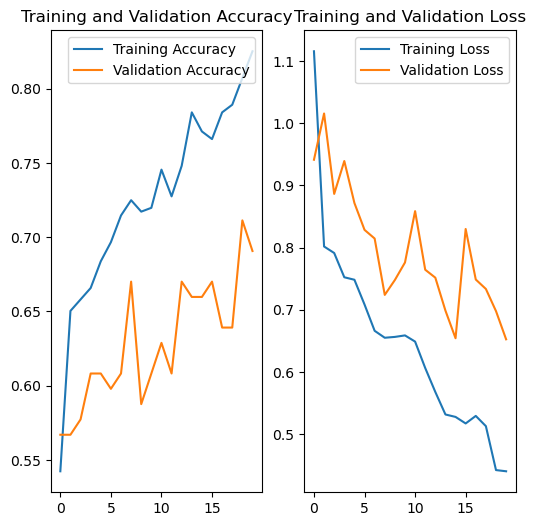

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize = (6,6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

In [12]:
unseen_img_files = "/kaggle/input/unseen-bottles/Water Bottle Classifier"
unseen_img_dir = pathlib.Path(unseen_img_files)
image_count = len(list(unseen_img_dir.glob('*.jpg')))
print("Unseen water images =", image_count)

Unseen water images = 5


In [13]:
unseen_img = "/kaggle/input/unseen-bottles/Water Bottle Classifier/waterbottle1.jpg"

img = tf.keras.utils.load_img(
    unseen_img, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(labels[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 140ms/step
This image most likely belongs to Full  Water level with a 95.79 percent confidence.
